# Monitoramento de carros
------------------------

## Importando a base e removendo "na" values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

local = r'C:\Users\mbraz\Downloads\VM201_2019.xlsx'

df = pd.read_excel(local)
df['Inicio'].replace("?", np.nan, inplace=True)
df.dropna(subset=['Inicio'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

### Transformando horas no formato datatime (00:00) para formato decimal (7,50 == 07:30)

In [2]:
def extract_hora(dataframe):
    return [int(i[0:2]) for i in dataframe]

def extract_minuto(dataframe):
    return [int(i[3:])/60 for i in dataframe]

ListaInicioHora = extract_hora(df['Inicio'])
ListaInicioMinuto = extract_minuto(df['Inicio'])
ListaFinalHora = extract_hora(df['Final'])
ListaFinalMinuto = extract_minuto(df['Final'])

def hora_total(listaHora, listaMinuto):
    return pd.DataFrame(listaHora) + pd.DataFrame(listaMinuto)

HoraInicio = hora_total(ListaInicioHora, ListaInicioMinuto)
HoraFinal = hora_total(ListaFinalHora, ListaFinalMinuto)

df['HoraInicio'] = HoraInicio
df['HoraFinal'] = HoraFinal

### Retirando dias com jornada de trabalho menor que 4h

In [3]:
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro']

df['Mês'] = pd.Categorical(df['Mês'], categories=meses, ordered=True)
df.sort_values('Mês', inplace=True)

dropRows = list()
for i in range(0, len(df)):
    horas = df['HoraFinal'][i] - df['HoraInicio'][i] 
    if horas <= 4:
        dropRows.append(i)

df.drop(dropRows, inplace=True)
df.reset_index(inplace=True, drop=True)

### Plotando gráfico

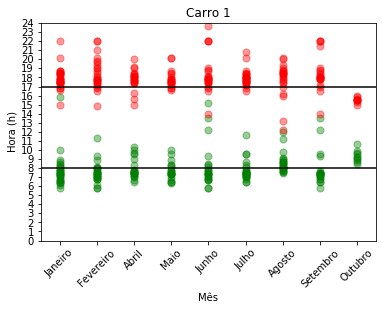

In [4]:
yInicio = df['HoraInicio']
yFinal = df['HoraFinal']
x = df['Mês']
plt.scatter(x, yInicio, color='g', s=50, alpha=0.4)
plt.scatter(x, yFinal, color='r', s=50, alpha=0.4)
plt.xticks(rotation=45)
plt.yticks(range(0, 25))
plt.ylim(0, 24)
plt.xlabel('Mês')
plt.ylabel('Hora (h)')
plt.title(f'Carro 1')
plt.axhline(y=17, color='black')
plt.axhline(y=8, color='black')
plt.show()

### Funções para cálculos

In [26]:
import operator

def comparador(entrada, operador, referencia):
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    return ops[operador](entrada, referencia)


def porcentagemMensal(dataFrame, coluna, condicao, limite): 
    '''
    Opções para o parâmetro condicao -> "=", ">", ">=", "<=", "<" 
    Parâmetro limite -> valor numérico para comparar 
    '''
    porcentagemList = []
    for mes in meses:
        count = 0
        porcentagem = 0
        dfMes = dataFrame.loc[dataFrame.Mês == mes]
        dfMes.reset_index(inplace=True, drop=True)
        for i in range(0, len(dfMes)):
            if comparador(dfMes[coluna][i], condicao, limite) == True:
                count += 1
        if count == 0:
            porcentagemList.append(0)
        else:
            porcentagem = int((count/dfMes.shape[0])*100)
            porcentagemList.append(porcentagem)
    return porcentagemList


def mediaMensal(dataFrame, coluna):
    listaMedia = []
    for mes in meses:
        dfMes = dataFrame.loc[dataFrame.Mês == mes]
        dfMes.reset_index(inplace=True, drop=True)
        listaMedia.append(round(dfMes[coluna].mean(), 1))
    return listaMedia


def mediaDiferenca(dataFrame, coluna1, coluna2):
    '''
    Operação efetuada -> coluna1 - coluna2
    '''
    mediaJornada = []
    for mes in meses:
        dfMes = dataFrame.loc[dataFrame.Mês == mes]
        dfMes.reset_index(inplace=True, drop=True)
        jornadaMensal = []
        for i in range(0, len(dfMes)):
            jornada = dfMes[coluna1][i] - dfMes[coluna2][i]     
            jornadaMensal.append(jornada)                 
        mediaJornada.append(round(np.mean(jornadaMensal),1))
    return mediaJornada


def decimalToTime(lista):
    for i, valor in enumerate(lista):
        try:
            if valor >= 10:
                if  int((valor%1)*60) < 10:
                    lista[i] = f'{int(valor)}:0{int((valor%1)*60)}'
                else:
                    lista[i] = f'{int(valor)}:{int((valor%1)*60)}'
            elif int((valor%1)*60) < 10:
                lista[i] = f'0{int(valor)}:0{int((valor%1)*60)}'
            else:
                lista[i] = f'0{int(valor)}:{int((valor%1)*60)}'
        except:
            lista[i] = '0'
    return lista

### Tabela de índices

In [225]:
tabela = pd.DataFrame()
tabela['Meses'] = meses

tabela['Inicio depois das 8h (%)'] = porcentagemMensal(df, 'HoraInicio', '>', 8)
tabela['Término antes das 17h (%)'] = porcentagemMensal(df, 'HoraFinal', '<', 17)
tabela['Horário médio de inicio (h)'] = decimalToTime(mediaMensal(df, 'HoraInicio'))
tabela['Horário médio de término (h)'] = decimalToTime(mediaMensal(df, 'HoraFinal'))
tabela['Tempo de trabalho médio (h/dia)'] = decimalToTime(mediaDiferenca(df, 'HoraFinal', 'HoraInicio'))

C:\Users\mbraz\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [226]:
tabela

,Meses,Inicio depois das 8h (%),Término antes das 17h (%),Horário médio de inicio (h),Horário médio de término (h),Tempo de trabalho médio (h/dia)
0,Janeiro,26,13,07:42,17:53,10:11
1,Fevereiro,15,11,07:30,18:23,10:54
2,Março,0,0,0,0,0
3,Abril,27,13,07:54,17:48,09:48
4,Maio,28,14,07:42,17:48,10:11
5,Junho,29,12,08:11,18:23,10:11
6,Julho,22,7,07:42,18:00,10:11
7,Agosto,69,17,08:35,17:41,09:05
8,Setembro,18,9,07:54,18:30,10:35
9,Outubro,100,100,09:18,15:30,06:12
